# NFL Big Data Bowl Clustering

## Import data

In [1]:
import pandas as pd

In [2]:
plays = pd.read_csv('Data/nfl-big-data-bowl-2022/plays.csv')
games = pd.read_csv('Data/nfl-big-data-bowl-2022/games.csv')
players = pd.read_csv('Data/nfl-big-data-bowl-2022/players.csv')
tracking2018 = pd.read_csv('Data/nfl-big-data-bowl-2022/tracking2018.csv')
tracking2019 = pd.read_csv('Data/nfl-big-data-bowl-2022/tracking2019.csv')
tracking2020 = pd.read_csv('Data/nfl-big-data-bowl-2022/tracking2020.csv')

## Preprocess Players Data

In [4]:
from NFL_BDB_2022.Preprocessing_makers import preprocess_players

In [5]:
players_df = preprocess_players(players)

## Preprocess Tracking Data

In [6]:
from NFL_BDB_2022.Preprocessing_makers import preprocess_tracking, preprocess_football_track

In [7]:
fg_tracking_2018, fg_tracking_2019, fg_tracking_2020 = preprocess_tracking(tracking2018, tracking2019, tracking2020, plays, 'Field Goal')

In [8]:
fg_tracking_ball = preprocess_football_track(fg_tracking_2018, fg_tracking_2019, fg_tracking_2020)

## Preprocess Play Data

In [9]:
from NFL_BDB_2022.Preprocessing_makers import preprocess_play
from NFL_BDB_2022.Cleaning_data import drop_by_index_difference

In [10]:
play_df = preprocess_play(plays)

In [11]:
play_df = drop_by_index_difference(play_df, fg_tracking_ball, 'field_goal_attempt')

## Make Field Goal DataFrame

In [12]:
from NFL_BDB_2022.Preprocessing_makers import make_fieldGoal

In [13]:
field_goal_df = make_fieldGoal(play_df, players_df)

## Feature Engineering

In [14]:
from NFL_BDB_2022.Feature_engineering import endzone_y_pos, expected_endzone_y_pos, kicker_core_dist

### Fieldgoal Y-Position

In [15]:
field_goal_df = endzone_y_pos(field_goal_df, fg_tracking_ball)

### Fieldgoal Trajectory Position

In [16]:
attempts_df = field_goal_df[field_goal_df['specialTeamsResult'].isin(['Kick Attempt Good', 'Kick Attempt No Good'])]

In [17]:
attempts_ids = attempts_df[['gameId', 'playId']]

In [18]:
attempts_tracking = pd.merge(attempts_ids, fg_tracking_ball, left_on = ['gameId', 'playId'], right_on = ['gameId', 'playId'])

In [19]:
attempts_event = attempts_tracking[attempts_tracking['event']=='field_goal_attempt']

In [20]:
attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)

/tmp/ipykernel_32430/3006702610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_event['mergeId'] = attempts_event['gameId'].astype(str) + attempts_event['playId'].astype(str)
/tmp/ipykernel_32430/3006702610.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attempts_ids['mergeId'] = attempts_ids['gameId'].astype(str) + attempts_ids['playId'].astype(str)


In [21]:
indices_to_drop = attempts_ids[~attempts_ids['mergeId'].isin(attempts_event['mergeId'])].index

In [22]:
#fg_tracking_ball[(fg_tracking_ball['gameId']==2018122302) & (fg_tracking_ball['playId']==1858)]

In [23]:
#fg_tracking_ball = fg_tracking_ball.drop(indices_to_drop)

In [24]:
attempts_df = attempts_df.drop(indices_to_drop)

In [25]:
attempts_df = expected_endzone_y_pos(attempts_df, fg_tracking_ball, 'field_goal_attempt')

/home/kenneth/Documents/NFL/NFL_BDB_2022/Feature_engineering.py:188: RuntimeWarning: invalid value encountered in double_scalars
  m = (y2-y1)/(x2-x1)


### Kicker Core Distance

While performing this compute, I discovered that it is apparently possible for a kicker not to be present for a play (???????????).

For an example of where this occurs, check out `gameId = 2019091502` and `playId = 2075` in the 2019 tracking data.

In [42]:
import numpy as np

def get_play(game_id, play_id, tracking):
    '''
    This function creates the tracking dataframes.

    Parameters:
    -----------
    game_id, play_id - game and play of interest
    tracking - tracking dataframe the that game and play are in
    ...

    Returns:
    -----------
    play - dataframe of just the tracking data for the particular play of interest
    '''
    game = tracking[tracking['gameId'] == game_id]
    play_ex = game[game['playId'] == play_id]
    
    return play_ex


# In[ ]:


def get_event(game_id, play_id, track_fp, event):
    '''
    This function creates a small dataframe for football tracking around the event.

    Parameters:
    -----------
    game_id, play_id - game and play of interest
    track_fp - football-specific tracking dataframe for play type
    event - string of the event that we want to find, i.e., 'extra_point_attempt'
    ...

    Returns:
    -----------
    event_df - 11-row dataframe of tracking data around the event
    event_index - the index of the moment of the kick based on max velocity
    #frame_id - frameId of event
    '''
    play_ex = get_play(game_id, play_id, track_fp)
    
    index = play_ex.index[play_ex['event']== event].values[0]
    event_df = play_ex.loc[index-5:index+5,:]
    event_index = event_df['s'].idxmax()

    if event_index == event_df.index[-1]:
        event_df = play_ex.loc[index-10:index+10,:]
        
    #frame_id = play_ex.loc[event_index]['frameId']
    
    return event_df, event_index

def l2_norm(x1, y1, x2, y2):
    # Computes euclidean distance between two points
    return np.sqrt(np.square(x1-x2) + np.square(y1-y2))

def get_opposing_team(kicking_team):
    # Returns label of opposing team
    return 'home' if kicking_team == 'away' else 'away'

def compute_kicker_core_dist(game_id, play_id, tracking, track_fp, event, k=5):
    '''
    Compute core distance from kicker to players on opposing team

    Parameters:
    -----------
    game_id - gameId of play
    play_id - playId of play
    tracking - Tracking data containing relevant play
    k - Number of nearest neighbors to check (returns distance of k-th nearest player)
    #we seem to need track_fp to get the event of the kick

    Returns:
    --------
    core_distance - The core distance from kicker to players on opposing team

    '''

    # Get play and event data
    play_ex = get_play(game_id, play_id, tracking)
    event_df, event_index = get_event(game_id, play_id, track_fp, event)

    
    # Get all play data at the time of the kick
    kick_frame = event_df.loc[event_index]['frameId']
    kick_tracking = play_ex[play_ex['frameId']==kick_frame]

    # Get data from players on opposing team
    try:
        kicking_team = kick_tracking[kick_tracking['position']=='K']['team'].values[0]
    except IndexError:

        '''
        Apparently there are cases in which a kicker isn't present (???)
        so if grabbing the kicker's team fails, just return null.
        '''

        return np.nan
        
    opposing_team = get_opposing_team(kicking_team)
    opposing_team_players = kick_tracking[kick_tracking['team']==opposing_team]

    # Get kicker x and y coords
    kicker_x = kick_tracking[kick_tracking['position']=='K']['x'].values[0]
    kicker_y = kick_tracking[kick_tracking['position']=='K']['y'].values[0]

    # Compute Euclidean distances from kicker to players on opposing team
    opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])

    # Sort distances, grab k-th nearest distance (the core distance)
    sorted_distances = opposing_team_players['kicker_dist'].sort_values()
    core_distance = sorted_distances.iloc[k-1]

    return core_distance



def kicker_core_dist(pt_play, tracking2018, tracking2019, tracking2020, track_fp, event, k=5):
    
    tracking = pd.concat([tracking2018, tracking2019, tracking2020])

    pt_play['kicker_core_dist'] = pt_play.index.map(
        lambda x: compute_kicker_core_dist(
            pt_play.loc[x]['gameId'],
            pt_play.loc[x]['playId'],
            tracking,
            track_fp,
            event,
            k=k
        )
    )

    return pt_play

In [43]:
attempts_df = kicker_core_dist(attempts_df, fg_tracking_2018, fg_tracking_2019, fg_tracking_2020, fg_tracking_ball, 'field_goal_attempt', k=3)

/tmp/ipykernel_32430/290977809.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


## Final Preprocessing Steps

In [44]:
from Preprocessing_makers import preprocess_fg

In [47]:
X, final_df = preprocess_fg(attempts_df)

## Clustering

In [61]:
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
model = hdbscan.HDBSCAN()

In [52]:
model_results = model.fit(X)

In [54]:
model_results.labels_.max()

2

In [64]:
final_df['cluster_id'] = model_results.labels_

/tmp/ipykernel_32430/1033965784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cluster_id'] = model_results.labels_


In [65]:
final_df['cluster_id'].value_counts()

 2    2003
 1     349
 0      25
-1      12
Name: cluster_id, dtype: int64

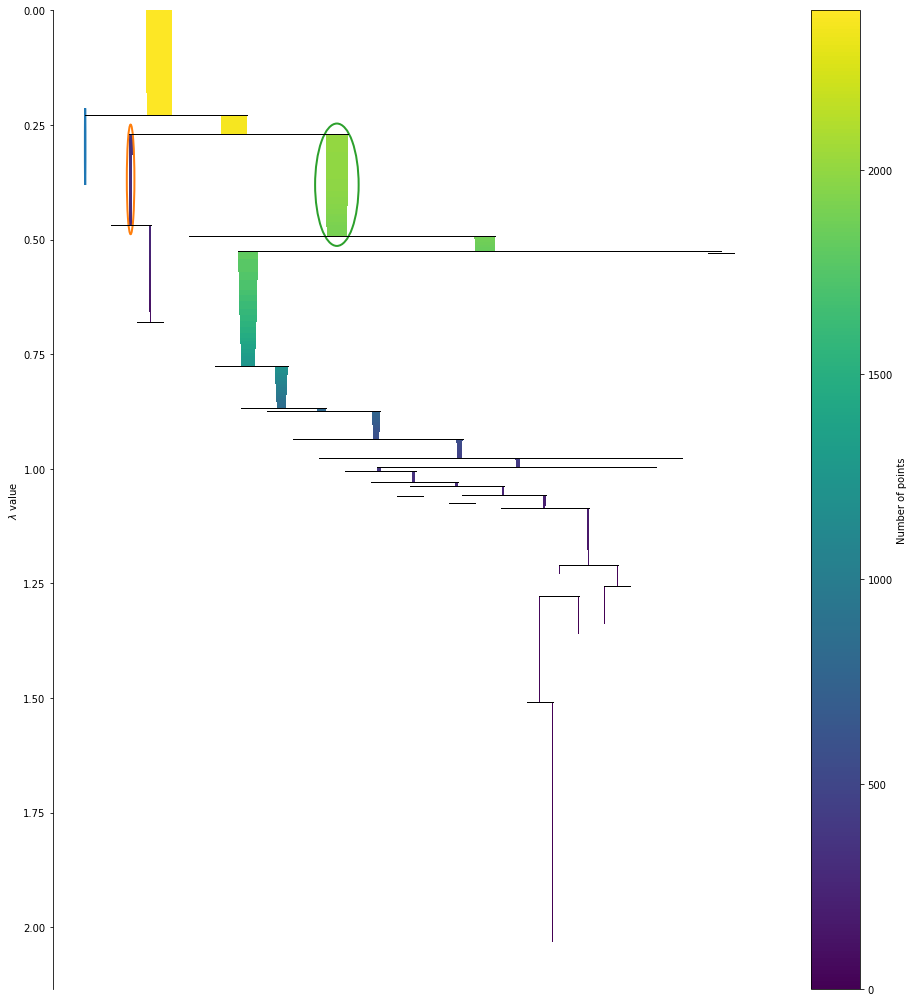

In [62]:
plt.figure(figsize = (16,18))
model.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [70]:
cluster0 = final_df[final_df['cluster_id']==0]
cluster1 = final_df[final_df['cluster_id']==1]
cluster2 = final_df[final_df['cluster_id']==2]

outliers = final_df[final_df['cluster_id']==-1]

In [67]:
cluster0['specialTeamsResult'].value_counts()

Kick Attempt Good    25
Name: specialTeamsResult, dtype: int64

In [68]:
cluster1['specialTeamsResult'].value_counts()

Kick Attempt No Good    349
Name: specialTeamsResult, dtype: int64

In [69]:
cluster2['specialTeamsResult'].value_counts()

Kick Attempt Good       2002
Kick Attempt No Good       1
Name: specialTeamsResult, dtype: int64

In [72]:
outliers['specialTeamsResult'].value_counts()

Kick Attempt Good       7
Kick Attempt No Good    5
Name: specialTeamsResult, dtype: int64